<a href="https://www.kaggle.com/tunguz/tps-dec-2021-simple-linear-baseline?scriptVersionId=83598331" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from cuml.linear_model import LogisticRegression
from cuml.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import RobustScaler
import gc



# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/tabular-playground-series-dec-2021/sample_submission.csv
/kaggle/input/tabular-playground-series-dec-2021/train.csv
/kaggle/input/tabular-playground-series-dec-2021/test.csv


In [2]:
sample_submission = pd.read_csv('/kaggle/input/tabular-playground-series-dec-2021/sample_submission.csv')
train = pd.read_csv('/kaggle/input/tabular-playground-series-dec-2021/train.csv')
test = pd.read_csv('/kaggle/input/tabular-playground-series-dec-2021/test.csv')

In [3]:
train.drop(columns=['Soil_Type7', 'Soil_Type15', 'Soil_Type1'], inplace=True) 
test.drop(columns=['Soil_Type7', 'Soil_Type15', 'Soil_Type1'], inplace=True) 

<AxesSubplot:>

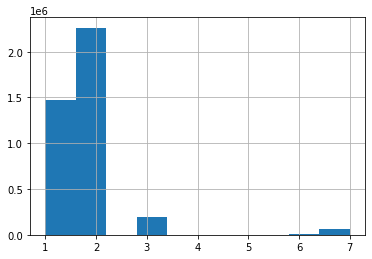

In [4]:
train['Cover_Type'].hist()

In [5]:
np.unique(train['Cover_Type'].values, return_counts=True)

(array([1, 2, 3, 4, 5, 6, 7]),
 array([1468136, 2262087,  195712,     377,       1,   11426,   62261]))

In [6]:
perm_dict = {1:2, 2:1, 3:3, 4:6, 7:4, 6:5, 5:7,}

In [7]:
inv_perm = {v: k for k, v in perm_dict.items()}
inv_perm

{2: 1, 1: 2, 3: 3, 6: 4, 4: 7, 5: 6, 7: 5}

<AxesSubplot:>

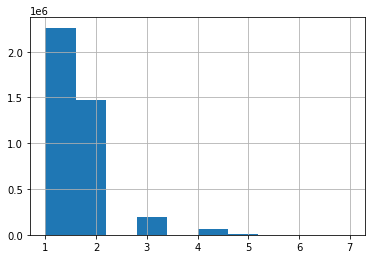

In [8]:
train['Cover_Type'].replace(perm_dict, inplace=True)
train['Cover_Type'].hist()

In [9]:
sample_submission.head()

,Id,Cover_Type
0,4000000,2
1,4000001,2
2,4000002,2
3,4000003,2
4,4000004,2


In [10]:
train.head()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,0,3189,40,8,30,13,3270,206,234,193,...,0,0,0,0,0,0,0,0,0,2
1,1,3026,182,5,280,29,3270,233,240,106,...,0,0,0,0,0,0,0,0,0,1
2,2,3106,13,7,351,37,2914,208,234,137,...,0,0,0,0,0,0,0,0,0,2
3,3,3022,276,13,192,16,3034,207,238,156,...,0,0,0,0,0,0,0,0,0,1
4,4,2906,186,13,266,22,2916,231,231,154,...,0,0,0,0,0,0,0,0,0,1


In [11]:
np.unique(train.Cover_Type.values, return_counts=True)

(array([1, 2, 3, 4, 5, 6, 7]),
 array([2262087, 1468136,  195712,   62261,   11426,     377,       1]))

In [12]:
test.head()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
0,4000000,2763,78,20,377,88,3104,218,213,195,...,0,0,0,0,0,0,0,0,0,0
1,4000001,2826,153,11,264,39,295,219,238,148,...,0,0,0,0,0,0,0,0,0,0
2,4000002,2948,57,19,56,44,852,202,217,163,...,0,0,1,0,0,0,0,0,0,0
3,4000003,2926,119,6,158,134,2136,234,240,142,...,0,0,0,0,0,0,0,0,0,0
4,4000004,2690,10,4,38,108,3589,213,221,229,...,0,0,0,0,0,0,0,0,0,0


In [13]:
columns = test.columns[1:]
columns

Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5', 'Soil_Type6',
       'Soil_Type8', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
       'Soil_Type13', 'Soil_Type14', 'Soil_Type16', 'Soil_Type17',
       'Soil_Type18', 'Soil_Type19', 'Soil_Type20', 'Soil_Type21',
       'Soil_Type22', 'Soil_Type23', 'Soil_Type24', 'Soil_Type25',
       'Soil_Type26', 'Soil_Type27', 'Soil_Type28', 'Soil_Type29',
       'Soil_Type30', 'Soil_Type31', 'Soil_Type32', 'Soil_Type33',
       'Soil_Type34', 'Soil_Type35', 'Soil_Type36', 'Soil_Type37',
       'Soil_Type38', 'Soil_Type39', 'Soil_Type40'],
      dtype='object')

In [14]:
np.sum(train.Cover_Type == 7)

1

In [15]:
np.sum(train.Cover_Type == 6)

377

In [16]:
train = train[train.Cover_Type !=7]
#train = train[train.Cover_Type !=6]
train.shape

(3999999, 53)

In [17]:
target = train[['Cover_Type']].values
train.drop(['Cover_Type', 'Id'], axis=1, inplace=True)
test.drop(['Id', ], axis=1, inplace=True)

In [18]:
%%time
train_test = pd.concat([train, test], axis =0)
RS = RobustScaler()
RS.fit(train_test)
del train_test
gc.collect()
gc.collect()
train = RS.transform(train)
test = RS.transform(test)
del RS
gc.collect()
gc.collect()

CPU times: user 6.78 s, sys: 1.08 s, total: 7.86 s
Wall time: 8.04 s


0

In [19]:
np.unique(target, return_counts=True)

(array([1, 2, 3, 4, 5, 6]),
 array([2262087, 1468136,  195712,   62261,   11426,     377]))

In [20]:
train_oof = np.zeros((train.shape[0],))
test_preds = 0
train_oof.shape

(3999999,)

In [21]:
%%time
n_splits = 5
kf = KFold(n_splits=n_splits, random_state=7, shuffle=True)

for jj, (train_index, val_index) in enumerate(kf.split(train)):
    print("Fitting fold", jj+1)
    train_features = train[train_index]
    train_target = target[train_index]

    
    val_features = train[val_index]
    val_target = target[val_index]
    print(np.unique(train_target, return_counts=True))
    print(np.unique(val_target, return_counts=True))

    
    model = LogisticRegression(C=1, solver='qn', max_iter=200, tol=0.000000001)
    model.fit(train_features, train_target)
    val_pred = model.predict(val_features)
    train_oof[val_index] = val_pred.flatten()
    test_preds += model.predict_proba(test)/n_splits
    print(accuracy_score(val_target,val_pred))
    del model
    gc.collect()
    gc.collect()

Fitting fold 1
(array([1, 2, 3, 4, 5, 6]), array([1809273, 1174631,  156645,   49947,    9190,     313]))
(array([1, 2, 3, 4, 5, 6]), array([452814, 293505,  39067,  12314,   2236,     64]))
[W] [14:21:36.239119] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
0.9172049760818481
Fitting fold 2
(array([1, 2, 3, 4, 5, 6]), array([1809862, 1174467,  156700,   49585,    9081,     304]))
(array([1, 2, 3, 4, 5, 6]), array([452225, 293669,  39012,  12676,   2345,     73]))
[W] [14:22:18.679823] L-BFGS: max iterations reached
[W] [14:22:18.680442] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
0.9172599911689758
Fitting fold 3
(array([1, 2, 3, 4, 5, 6]), array([1809638, 1174622,  156524,   49758,    9174,     283]))
(array([1, 2, 3, 4, 5, 6]), array([452449, 293514,  39188,  12503,   2252,     94]))
[W] [14:22:55.193387] L-BFGS stop

In [22]:
print(accuracy_score(target,train_oof))

0.9172444939613342


In [23]:
test_preds

array([[1.06633208e-07, 9.99182585e-01, 7.18135334e-04, 7.68882049e-05,
        1.23148848e-08, 2.22723192e-05],
       [2.40283198e-07, 9.89927297e-01, 1.00719344e-02, 4.71416223e-08,
        4.35229886e-07, 4.58497232e-08],
       [2.49565429e-07, 9.17981449e-01, 8.20017911e-02, 1.65109475e-09,
        1.65031598e-05, 5.76662508e-09],
       ...,
       [4.61114501e-08, 9.99834320e-01, 1.65607816e-04, 5.26670071e-10,
        1.33716679e-08, 1.19178233e-08],
       [1.37894873e-11, 1.14321169e-02, 9.84251675e-01, 2.82077715e-14,
        4.31620774e-03, 1.41926623e-13],
       [1.10525997e-06, 8.27278143e-02, 8.21053119e-08, 9.08822832e-01,
        2.60273012e-12, 8.44816602e-03]])

In [24]:
preds = np.argmax(test_preds, axis=1)
preds

array([1, 1, 1, ..., 1, 2, 3])

In [25]:
np.unique(preds, return_counts=True)

(array([0, 1, 2, 3, 4, 5]),
 array([     8, 502154, 402791,  83697,   8791,   2559]))

In [26]:
preds[np.where(preds == 0)[0]] = 1

In [27]:
sample_submission['Cover_Type'] = preds
sample_submission['Cover_Type'].replace(inv_perm, inplace=True)
sample_submission.head()

,Id,Cover_Type
0,4000000,2
1,4000001,2
2,4000002,2
3,4000003,2
4,4000004,2


In [28]:
np.unique(sample_submission['Cover_Type'].values)

array([1, 2, 3, 6, 7])

In [29]:
sample_submission.to_csv('submission.csv', index=False)

